<a href="https://colab.research.google.com/github/Vinnesta/l45-music-gnn/blob/main/L45_Mozart_is_a_GNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <font color=green> Simple Model Architecture

Code Note:  
https://hackmd.io/@0Y_ZosHzSjKcz7sGAMMIXA/SyGTs-e6o/edit

## Environment set up

In [1]:
# install packages
!pip install networkx

import torch
!pip install torch-geometric torch-scatter torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch_geometric
from torch_scatter import scatter_mean, scatter_max, scatter_sum
from torch_geometric.utils.convert import from_scipy_sparse_matrix

import numpy as np
import random

#for nice visualisations
import networkx as nx
import matplotlib.pyplot as plt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.13.1+cu116.html


## High parameter for data structure

In [2]:
# High parameters for data structure
music_len = 100
time_steps = 5
number_nodes = 12

### Generate test code

In [3]:
# functio which takes music sequence and window size(history length) and return training data.
# music = Time_step x Num_nodes
def slice_temporal_data(music_seq,window_size=5):
  return [[torch.transpose(music_seq[i:i+5],0,1),music_seq[i+5].reshape(-1,1)] for i in range(len(music_seq)-window_size)]


In [4]:
# geberate toy music sequence and process it as traning data
toy_music = (torch.rand(music_len,number_nodes)<0.5).to(torch.float)
data = slice_temporal_data(toy_music,window_size=5)
print("Input: ",data[0][0])
print("Output: ",data[0][1])

Input:  tensor([[0., 1., 0., 0., 0.],
        [1., 1., 0., 0., 1.],
        [0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 1.],
        [1., 1., 1., 1., 0.],
        [1., 1., 0., 1., 0.],
        [0., 0., 1., 1., 1.],
        [0., 1., 1., 0., 0.],
        [0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 1.],
        [1., 0., 0., 1., 1.],
        [0., 0., 1., 1., 0.]])
Output:  tensor([[0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.]])


In [5]:
# Toy adjacency matrix for testing
toy_adj_mat = (torch.rand(number_nodes,number_nodes)<0.5).to(torch.float)
print("Adjancy Matrix: ",toy_adj_mat)
print("Edge_index: ",toy_adj_mat.to_sparse())

toy_deg = torch.diag(torch.sum(toy_adj_mat, 1))
print("Degree Matrix: ",toy_deg)

Adjancy Matrix:  tensor([[0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 1., 0.],
        [0., 1., 0., 0., 1., 0., 1., 1., 1., 0., 1., 0.],
        [0., 1., 0., 1., 1., 1., 0., 1., 0., 1., 0., 0.],
        [1., 1., 1., 0., 0., 0., 1., 0., 1., 1., 0., 0.],
        [0., 0., 1., 0., 1., 0., 1., 0., 1., 1., 0., 1.],
        [1., 1., 1., 1., 0., 1., 0., 0., 1., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 1., 1., 1., 0., 0.],
        [1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0.],
        [1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1.],
        [1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1.],
        [0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0.]])
Edge_index:  tensor(indices=tensor([[ 0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  2,  2,  2,
                         2,  2,  2,  3,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,
                         4,  5,  5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  7,
                         7,  7,  

## Data Processing

In [6]:
import torch

def create_tonnetz_adjacency_matrix(num_notes):
  # In Tonnetz, each node has six neighbours which have pitches of the following distances (in semi-tones)
  # E.g. C4 has neighbours F3, G#3, A3, D#4, E4, G4
  NEIGHBOUR_DISTANCES = [-7, -4, -3, 3, 4, 7]
  A = []

  for i in range(num_notes):
    row = torch.zeros(num_notes, dtype=torch.int)
    for d in NEIGHBOUR_DISTANCES:
      j = i+d
      if j >= 0 and j < num_notes:
        row[j] = 1
    A.append(row)
  return torch.stack(A)

A = create_tonnetz_adjacency_matrix(number_nodes)

# Check that A is symmetric since the Tonnetz graph is undirected
assert(torch.equal(A, A.transpose(0, 1)))

## Model architecture examples

In [7]:
from torch_geometric.nn import GCNConv

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


### Prepare dataset
May be need to do another batching methods. In current way, the node infmormation is separated, so that structural information is not well captured.

It should be;
- train_pred = model(X)[train_mask]
- train_label = label[train_mask]
- test_pred = model(X)[test_mask]
- test_label = label[test_mask]

In [8]:
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

data_X = torch.stack([d[0] for d in data])
y = torch.stack([d[1] for d in data])
#print(y.shape)
data_Y = np.zeros((y.shape[0],y.shape[1],2))
for i,nodes in enumerate(y):
  for j,node in enumerate(nodes):
    data_Y[i][j][int(node)] = 1.0
data_Y = torch.tensor(data_Y)
X_train, X_test, y_train, y_test = train_test_split(data_X, data_Y, test_size=0.33, random_state=42)
print(X_train.shape)
print(y_train.shape)

train_dataset = TensorDataset(X_train, y_train)
valid_dataset = TensorDataset(X_test, y_test)

batch_size = 8
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

torch.Size([63, 12, 5])
torch.Size([63, 12, 2])


### Model example 1

In [9]:
class SimpleModel01(nn.Module):
    # input_dim = dim of node features
    # output_dim = number of class which is ON/OFF
    def __init__(self, adj_mat, input_dim, hidden_dim=0, output_dim=2):
        super(SimpleModel01, self).__init__()
        self.adj_mat = adj_mat
        self.edge_index = self.adj_mat.to_sparse().indices().to(device)
        #print(self.edge_index)
        
        # GCN layers
        self.gcn_conv1 = GCNConv(input_dim,output_dim)

    def forward(self, x):
        x = self.gcn_conv1(x,self.edge_index)
        y_hat = F.log_softmax(x)
        return y_hat


------------------------------------------------------
epoch 1/100


<ipython-input-9-af08e50a5694>:15: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = F.log_softmax(x)


Train_Loss: 14.9988 Train_Acc: 5.9174
Test_Loss: 14.9937 Test_Acc: 6.3438

------------------------------------------------------
epoch 2/100
Train_Loss: 14.9830 Train_Acc: 5.8504
Test_Loss: 14.9784 Test_Acc: 6.3750

------------------------------------------------------
epoch 3/100
Train_Loss: 14.9702 Train_Acc: 5.6964
Test_Loss: 14.9641 Test_Acc: 6.3438

------------------------------------------------------
epoch 4/100
Train_Loss: 14.9717 Train_Acc: 5.8661
Test_Loss: 14.9504 Test_Acc: 6.3750

------------------------------------------------------
epoch 5/100
Train_Loss: 14.9584 Train_Acc: 5.7612
Test_Loss: 14.9400 Test_Acc: 6.3438

------------------------------------------------------
epoch 6/100
Train_Loss: 14.9399 Train_Acc: 5.6518
Test_Loss: 14.9309 Test_Acc: 6.4062

------------------------------------------------------
epoch 7/100
Train_Loss: 14.9230 Train_Acc: 5.7143
Test_Loss: 14.9226 Test_Acc: 6.3750

------------------------------------------------------
epoch 8/100
Train_

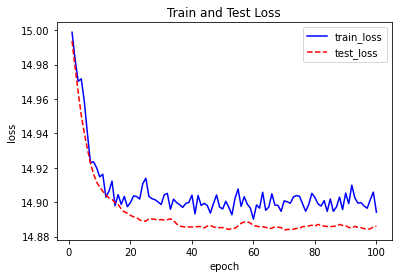

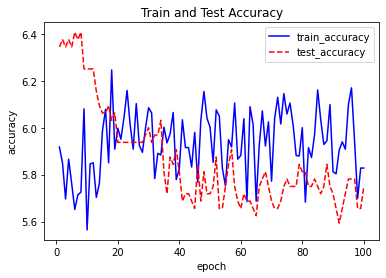

In [10]:
net = SimpleModel01(toy_adj_mat,time_steps, output_dim=2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
epoch = 100

# learnig loop
# Training
train_loss_list = []
train_acc_list = []
test_loss_list = []
test_acc_list = []

for i in range(epoch):
    print("\n------------------------------------------------------")
    print("epoch {}/{}".format(i+1,epoch))
    
    train_loss = 0
    train_acc = 0
    test_loss = 0
    test_acc = 0
    
    net.train()
    for data,label in train_dataloader:
        data = data.to(device)
        label = label.to(device)
        optimizer.zero_grad()
        #print(data.shape)
        y_pred_prob = net(data)
        #print(y_pred_prob.shape)
        loss = criterion(y_pred_prob,label)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        y_pred = torch.max(y_pred_prob,2)[1]                        #[1] is indicies of the resulting tensor
        label_max = torch.max(label)
        #print(y_pred.shape,label.shape)
        train_acc += torch.sum(y_pred==label_max).item()/len(label)
    batch_train_loss = train_loss/len(train_dataloader)
    batch_train_acc = train_acc/len(train_dataloader)
    
    net.eval()
    with torch.no_grad():
        for data,label in valid_dataloader:
            data = data.to(device)
            label = label.to(device)
            y_pred_prob = net(data)
            loss = criterion(y_pred_prob,label)
            test_loss += loss.item()
            y_pred = torch.max(y_pred_prob,2)[1]
            label_max = torch.max(label)
            test_acc += torch.sum(y_pred==label_max).item()/len(label)
    batch_test_loss = test_loss/len(valid_dataloader)
    batch_test_acc = test_acc/len(valid_dataloader)
    print("Train_Loss: {:.4f} Train_Acc: {:.4f}".format(batch_train_loss, batch_train_acc))
    print("Test_Loss: {:.4f} Test_Acc: {:.4f}".format(batch_test_loss,batch_test_acc))

    train_loss_list.append(batch_train_loss)
    train_acc_list.append(batch_train_acc)
    test_loss_list.append(batch_test_loss)
    test_acc_list.append(batch_test_acc)

# visualizing training process
plt.figure()
plt.title("Train and Test Loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.plot(range(1,epoch+1),train_loss_list,color="b",linestyle="-",label="train_loss")
plt.plot(range(1,epoch+1),test_loss_list,color="r",linestyle="--",label="test_loss")
plt.legend()
plt.figure()
plt.title("Train and Test Accuracy")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.plot(range(1,epoch+1),train_acc_list,color="b",linestyle="-",label="train_accuracy")
plt.plot(range(1,epoch+1),test_acc_list,color="r",linestyle="--",label="test_accuracy")
plt.legend()
plt.show()

### Model example 2

In [11]:
class SimpleModel02(nn.Module):
    # input_dim = dim of node features
    # output_dim = number of class which is ON/OFF
    def __init__(self, adj_mat, input_dim, hidden_dim, output_dim=2):
        super(SimpleModel02, self).__init__()
        self.adj_mat = adj_mat
        self.edge_index = self.adj_mat.to_sparse().indices().to(device)
        
        # GCN layers
        self.gcn_conv1 = GCNConv(input_dim,hidden_dim)
        
        # Linear layers
        self.linear = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.gcn_conv1(x,self.edge_index)
        x = F.relu(x)
        y_hat = F.log_softmax(self.linear(x))
        return y_hat


------------------------------------------------------
epoch 1/100
Train_Loss: 14.9032 Train_Acc: 6.5714
Test_Loss: 14.9008 Test_Acc: 6.0312

------------------------------------------------------
epoch 2/100
Train_Loss: 14.9056 Train_Acc: 6.1317
Test_Loss: 14.9046 Test_Acc: 6.3750

------------------------------------------------------
epoch 3/100
Train_Loss: 14.8953 Train_Acc: 6.4643
Test_Loss: 14.9054 Test_Acc: 6.5938

------------------------------------------------------
epoch 4/100
Train_Loss: 14.9012 Train_Acc: 6.4330
Test_Loss: 14.9009 Test_Acc: 6.2812

------------------------------------------------------
epoch 5/100
Train_Loss: 14.9022 Train_Acc: 6.3616
Test_Loss: 14.8955 Test_Acc: 5.9688

------------------------------------------------------
epoch 6/100
Train_Loss: 14.8965 Train_Acc: 6.5915
Test_Loss: 14.8963 Test_Acc: 6.1562

------------------------------------------------------
epoch 7/100


<ipython-input-11-ebf8f0617d05>:18: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = F.log_softmax(self.linear(x))


Train_Loss: 14.8910 Train_Acc: 6.4821
Test_Loss: 14.8976 Test_Acc: 6.2188

------------------------------------------------------
epoch 8/100
Train_Loss: 14.8921 Train_Acc: 6.4688
Test_Loss: 14.8939 Test_Acc: 6.0938

------------------------------------------------------
epoch 9/100
Train_Loss: 14.8929 Train_Acc: 6.2902
Test_Loss: 14.8906 Test_Acc: 6.0938

------------------------------------------------------
epoch 10/100
Train_Loss: 14.8875 Train_Acc: 6.3237
Test_Loss: 14.8898 Test_Acc: 6.0625

------------------------------------------------------
epoch 11/100
Train_Loss: 14.8889 Train_Acc: 6.4955
Test_Loss: 14.8896 Test_Acc: 6.1250

------------------------------------------------------
epoch 12/100
Train_Loss: 14.8811 Train_Acc: 6.3683
Test_Loss: 14.8888 Test_Acc: 6.2500

------------------------------------------------------
epoch 13/100
Train_Loss: 14.8768 Train_Acc: 6.3951
Test_Loss: 14.8928 Test_Acc: 6.3438

------------------------------------------------------
epoch 14/100
T

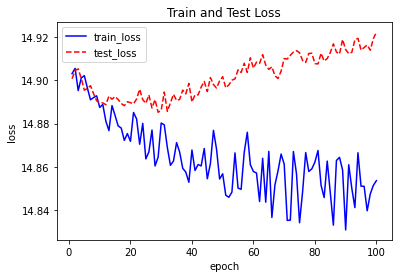

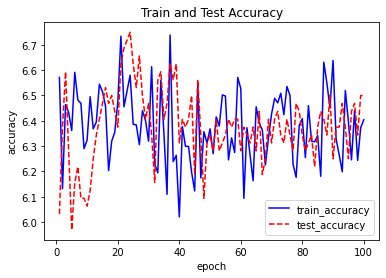

In [12]:
net = SimpleModel02(toy_adj_mat,time_steps,3,output_dim=2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
epoch = 100

# learnig loop
# Training
train_loss_list = []
train_acc_list = []
test_loss_list = []
test_acc_list = []

for i in range(epoch):
    print("\n------------------------------------------------------")
    print("epoch {}/{}".format(i+1,epoch))
    
    train_loss = 0
    train_acc = 0
    test_loss = 0
    test_acc = 0
    
    net.train()
    for data,label in train_dataloader:
        data = data.to(device)
        label = label.to(device)
        optimizer.zero_grad()
        y_pred_prob = net(data)
        #print(y_pred_prob)
        loss = criterion(y_pred_prob,label)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        y_pred = torch.max(y_pred_prob,2)[1]                        #[1] is indicies of the resulting tensor
        label_max = torch.max(label)
        #print(y_pred.shape,label.shape)
        train_acc += torch.sum(y_pred==label_max).item()/len(label)
    batch_train_loss = train_loss/len(train_dataloader)
    batch_train_acc = train_acc/len(train_dataloader)
    
    net.eval()
    with torch.no_grad():
        for data,label in valid_dataloader:
            data = data.to(device)
            label = label.to(device)
            y_pred_prob = net(data)
            loss = criterion(y_pred_prob,label)
            test_loss += loss.item()
            y_pred = torch.max(y_pred_prob,2)[1]
            label_max = torch.max(label)
            test_acc += torch.sum(y_pred==label_max).item()/len(label)
    batch_test_loss = test_loss/len(valid_dataloader)
    batch_test_acc = test_acc/len(valid_dataloader)
    print("Train_Loss: {:.4f} Train_Acc: {:.4f}".format(batch_train_loss, batch_train_acc))
    print("Test_Loss: {:.4f} Test_Acc: {:.4f}".format(batch_test_loss,batch_test_acc))

    train_loss_list.append(batch_train_loss)
    train_acc_list.append(batch_train_acc)
    test_loss_list.append(batch_test_loss)
    test_acc_list.append(batch_test_acc)

# visualizing training process
plt.figure()
plt.title("Train and Test Loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.plot(range(1,epoch+1),train_loss_list,color="b",linestyle="-",label="train_loss")
plt.plot(range(1,epoch+1),test_loss_list,color="r",linestyle="--",label="test_loss")
plt.legend()
plt.figure()
plt.title("Train and Test Accuracy")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.plot(range(1,epoch+1),train_acc_list,color="b",linestyle="-",label="train_accuracy")
plt.plot(range(1,epoch+1),test_acc_list,color="r",linestyle="--",label="test_accuracy")
plt.legend()
plt.show()

### Model example 3

In [13]:
class SimpleModel03(nn.Module):
    # input_dim = dim of node features
    # output_dim = number of class which is ON/OFF
    def __init__(self, adj_mat, input_dim, hidden_dim, output_dim=2):
        super(SimpleModel03, self).__init__()
        self.adj_mat = adj_mat
        self.edge_index = self.adj_mat.to_sparse().indices().to(device)
        
        # GCN layers
        self.gcn_conv1 = GCNConv(input_dim,hidden_dim)
        self.gcn_conv2 = GCNConv(hidden_dim,hidden_dim)
        
        # Linear layers
        self.linear = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.gcn_conv1(x,self.edge_index)
        x = F.relu(x)
        x = self.gcn_conv2(x,self.edge_index)
        x = F.relu(x)
        y_hat = F.log_softmax(self.linear(x))
        return y_hat


------------------------------------------------------
epoch 1/100
Train_Loss: 14.9137 Train_Acc: 5.7746
Test_Loss: 14.8836 Test_Acc: 5.4375

------------------------------------------------------
epoch 2/100
Train_Loss: 14.9053 Train_Acc: 5.8951
Test_Loss: 14.8842 Test_Acc: 5.5000

------------------------------------------------------
epoch 3/100
Train_Loss: 14.9112 Train_Acc: 5.9330
Test_Loss: 14.8842 Test_Acc: 5.5625

------------------------------------------------------
epoch 4/100
Train_Loss: 14.9031 Train_Acc: 6.2478
Test_Loss: 14.8850 Test_Acc: 5.4375

------------------------------------------------------
epoch 5/100
Train_Loss: 14.8945 Train_Acc: 6.4420
Test_Loss: 14.8851 Test_Acc: 5.4688

------------------------------------------------------
epoch 6/100
Train_Loss: 14.8926 Train_Acc: 6.1205
Test_Loss: 14.8843 Test_Acc: 5.5000

------------------------------------------------------
epoch 7/100


<ipython-input-11-ebf8f0617d05>:18: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = F.log_softmax(self.linear(x))


Train_Loss: 14.8971 Train_Acc: 5.9129
Test_Loss: 14.8834 Test_Acc: 5.5938

------------------------------------------------------
epoch 8/100
Train_Loss: 14.8898 Train_Acc: 5.9732
Test_Loss: 14.8843 Test_Acc: 5.8438

------------------------------------------------------
epoch 9/100
Train_Loss: 14.8992 Train_Acc: 6.1629
Test_Loss: 14.8868 Test_Acc: 6.0938

------------------------------------------------------
epoch 10/100
Train_Loss: 14.8803 Train_Acc: 6.2589
Test_Loss: 14.8855 Test_Acc: 5.9062

------------------------------------------------------
epoch 11/100
Train_Loss: 14.8842 Train_Acc: 6.1585
Test_Loss: 14.8852 Test_Acc: 5.7812

------------------------------------------------------
epoch 12/100
Train_Loss: 14.8704 Train_Acc: 6.3438
Test_Loss: 14.8875 Test_Acc: 6.0000

------------------------------------------------------
epoch 13/100
Train_Loss: 14.8789 Train_Acc: 6.1228
Test_Loss: 14.8878 Test_Acc: 5.8125

------------------------------------------------------
epoch 14/100
T

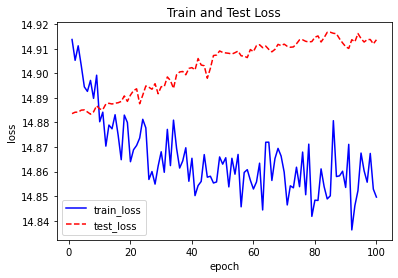

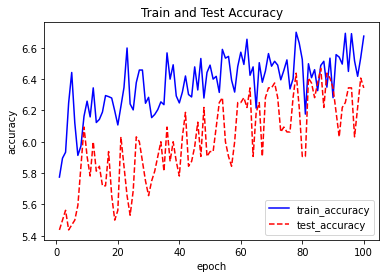

In [14]:
net = SimpleModel02(toy_adj_mat,time_steps,3,output_dim=2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
epoch = 100

# learnig loop
# Training
train_loss_list = []
train_acc_list = []
test_loss_list = []
test_acc_list = []

for i in range(epoch):
    print("\n------------------------------------------------------")
    print("epoch {}/{}".format(i+1,epoch))
    
    train_loss = 0
    train_acc = 0
    test_loss = 0
    test_acc = 0
    
    net.train()
    for data,label in train_dataloader:
        data = data.to(device)
        label = label.to(device)
        optimizer.zero_grad()
        y_pred_prob = net(data)
        #print(y_pred_prob)
        loss = criterion(y_pred_prob,label)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        # max in dim 2 because of shape (batch, nodes, feats)
        y_pred = torch.max(y_pred_prob,2)[1]                        #[1] is indicies of the resulting tensor
        label_max = torch.max(label)
        #print(y_pred.shape,label.shape)
        train_acc += torch.sum(y_pred==label_max).item()/len(label)
    batch_train_loss = train_loss/len(train_dataloader)
    batch_train_acc = train_acc/len(train_dataloader)
    
    net.eval()
    with torch.no_grad():
        for data,label in valid_dataloader:
            data = data.to(device)
            #print(data.shape)
            label = label.to(device)
            y_pred_prob = net(data)
            loss = criterion(y_pred_prob,label)
            test_loss += loss.item()
            # max in dim 2 because of shape (batch, nodes, feats)
            y_pred = torch.max(y_pred_prob,2)[1]
            label_max = torch.max(label)
            test_acc += torch.sum(y_pred==label_max).item()/len(label)
    batch_test_loss = test_loss/len(valid_dataloader)
    batch_test_acc = test_acc/len(valid_dataloader)
    print("Train_Loss: {:.4f} Train_Acc: {:.4f}".format(batch_train_loss, batch_train_acc))
    print("Test_Loss: {:.4f} Test_Acc: {:.4f}".format(batch_test_loss,batch_test_acc))

    train_loss_list.append(batch_train_loss)
    train_acc_list.append(batch_train_acc)
    test_loss_list.append(batch_test_loss)
    test_acc_list.append(batch_test_acc)

# visualizing training process
plt.figure()
plt.title("Train and Test Loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.plot(range(1,epoch+1),train_loss_list,color="b",linestyle="-",label="train_loss")
plt.plot(range(1,epoch+1),test_loss_list,color="r",linestyle="--",label="test_loss")
plt.legend()
plt.figure()
plt.title("Train and Test Accuracy")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.plot(range(1,epoch+1),train_acc_list,color="b",linestyle="-",label="train_accuracy")
plt.plot(range(1,epoch+1),test_acc_list,color="r",linestyle="--",label="test_accuracy")
plt.legend()
plt.show()

## Generate music sequence

In [39]:
def generate(model,first_history,generation_step=100):
  model.eval()
  history = first_history
  for i in range(generation_step):
    data = history[:,-5:].reshape(1,-1,time_steps)
    #print(data.shape)
    y_pred_prob = model(data)
    #print(y_pred_prob.shape)
    #print(y_pred_prob)
    y_pred = torch.max(y_pred_prob,2)[1]
    y_pred = y_pred.reshape(-1,1)
    #print(history.shape)
    #print(y_pred.shape)
    #print(y_pred)
    history = torch.hstack((history,y_pred))
    #print(history.shape)
  return history


In [41]:
random_history = (torch.rand(12,time_steps)>0.5).to(torch.float).to(device)
#print(random_history.shape)
music = generate(net,random_history)
print(music.shape)

torch.Size([12, 105])


<ipython-input-11-ebf8f0617d05>:18: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = F.log_softmax(self.linear(x))
